# Solving a QUBO using QOAO ansatz in qiskit

In [1]:
import sys
sys.path.append('../')
from src.loaddata import LoadData
from src.qubo import Qubo
import src.qubo_utils as qutils

In [2]:
# LoadData does all the file loading
ld = LoadData()

# Qubo computes all the qubo matrices given the 3d rism files and rescaled positions of registers from LoadData.
q = Qubo(ld)

In [3]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

In [4]:
#QAOA approach

# General imports
import numpy as np

# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp
from qiskit.visualization import plot_distribution

# IBM Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.primitives import Estimator, Sampler

# SciPy minimizer routine
from scipy.optimize import minimize

from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')


In [5]:
# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

def cost_func(params, ansatz, ising_ham, estimator):
    """Return estimate of energy from estimator

    Parameters:
        params (ndarray): Array of ansatz parameters
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        hamiltonian (SparsePauliOp): Operator representation of Hamiltonian
        estimator (Estimator): Estimator primitive instance

    Returns:
        float: Energy estimate
    """
    result = estimator.run(ansatz, ising_ham, parameter_values=params).result()
    cost = result.values[0]
    return cost


estimator = Estimator(options={"shots": int(1e4)})
sampler = Sampler(options={"shots": int(1e4)})

In [6]:
#qaoa_ansatz.decompose(reps=1).draw("mpl")

In [7]:
from qiskit import transpile 
from qiskit import Aer

backend = Aer.get_backend('aer_simulator')
qaoa_ansatz_compiled = transpile(qaoa_ansatz, backend)
print(qaoa_ansatz_compiled.count_ops(), qaoa_ansatz_compiled.depth())

#qaoa_ansatz_compiled.decompose(reps=1).draw("mpl")

OrderedDict([('rzz', 12), ('u2', 4), ('rz', 4), ('rx', 4)]) 16


OrderedDict([('ry', 8), ('cx', 3)]) 5


/Users/farrokhlabib/Documents/github/aquapointer/.venv/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


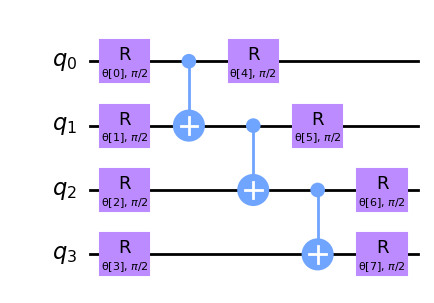

In [8]:
twolocal_ansatz_compiled = transpile(twolocal_ansatz, backend)
print(twolocal_ansatz_compiled.count_ops(), twolocal_ansatz_compiled.depth())
twolocal_ansatz_compiled.decompose(reps=1).draw("mpl")

In [9]:
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
x0 = beta+gamma
# x0 = 2 * np.pi * np.random.rand(ansatz.num_parameters)
res = minimize(cost_func, x0, args=(qaoa_ansatz, ising_ham, estimator), method="COBYLA")
res

     fun: 0.059710022260795276
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 32
  status: 1
 success: True
       x: array([2.47520055, 2.03720159])

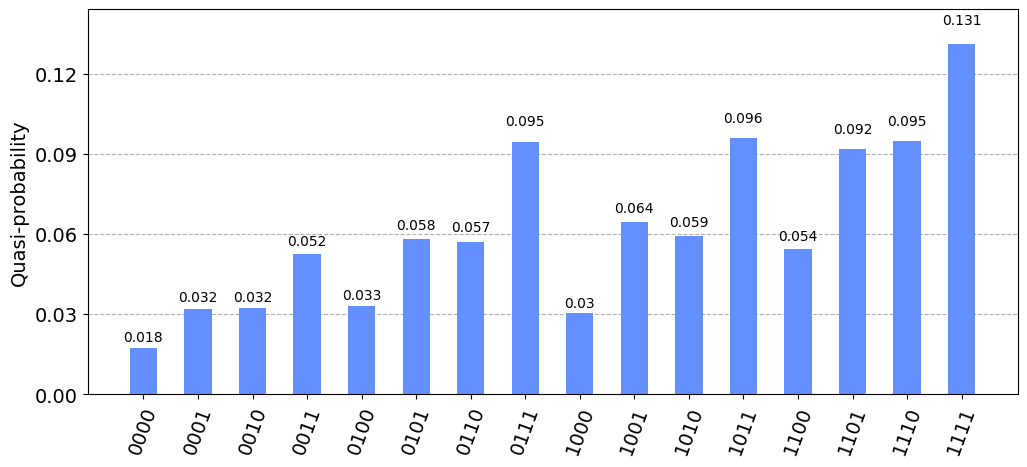

In [10]:
# Assign solution parameters to ansatz
qc = qaoa_ansatz.assign_parameters(res.x)
# Add measurements to our circuit
qc.measure_all()
# Sample ansatz at optimal parameters
samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]

plot_distribution(samp_dist.binary_probabilities(), figsize=(12, 5))

In [11]:
# classical brute-force solution
sol, ref_value = q.find_optimum(qubo=qubo)
sol, ref_value

('1000', -0.010743767178636635)

# using vqe.py module

In [12]:
from src.vqe import VQE

# vqe with twolocal ansatz
vqe = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)

In [13]:
res = vqe.run(alpha=1.0)
vqe.cvar_energy(params=vqe.params, alpha=1.0)

-0.010743767178636635

In [14]:
#vqe with qaoa ansatz
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)

In [15]:
res = vqe_qaoa.run(alpha=1.0)
vqe_qaoa.cvar_energy(params=vqe_qaoa.params, alpha=1.0)

0.11401327480073187

In [16]:
vqe_qaoa.cvar_energy(params=vqe_qaoa.params, alpha=0.5)

0.019759739978370945

In [17]:
from qiskit.primitives import Sampler
sampler = Sampler(options={"shots": int(1e4)})

#apply variational algorithm for different values of alpha, defining the cost function using CVaR
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

In [18]:
def prob_optimal_solution(vqe_object: VQE, alpha: float, N: int, verbose=False) -> tuple[float, int]:
    # if qaoa:
    #     params = beta + gamma
    #     vqe_object.params = params
    # else:
    #     params = np.array([np.random.random()]*vqe_object.ansatz.num_parameters)
    #     vqe_object.params = params

    res = vqe_object.run(alpha=alpha, method='COBYLA')
    nfev = res.nfev

    # Assign solution parameters to ansatz
    qc = vqe_object.ansatz.assign_parameters(vqe_object.params)
    # Add measurements to our circuit
    qc.measure_all()
    # Sample ansatz at optimal parameters
    samp_dist = sampler.run(qc, shots=int(1e4)).result().quasi_dists[0]
    samp_dist_binary = samp_dist.binary_probabilities()
    ##print(samp_dist_binary)

    correct_dist = {}
    for key in samp_dist_binary.keys():
        reverse_key = key[::-1]
        keynot = [(int(b)+1)%2 for b in reverse_key]
        correct_dist[''.join(map(str, keynot))] = samp_dist_binary[key]

    prob_energy = []
    bitstrings = []
    for key in correct_dist.keys():
        key_np = np.fromiter(map(int, key), dtype=int)
        prob_energy.append([correct_dist[key], qutils.ising_energy(key_np, qubo)])
        bitstrings.append(key)

    bitstrings = np.array(bitstrings)
    prob_energy = np.array(prob_energy)

    sorted_indices = np.argsort(prob_energy[:, 1])
    sorted_keys = bitstrings[sorted_indices]
    sorted_values = prob_energy[:, 1][sorted_indices]
    
    #pick top 10% of lowest observed energies and compute probability mass on them
    n = len(prob_energy)//N
    if verbose:
        if n<=1:
            print(prob_energy)

    total_mass = 0.0
    top_avg_energy = 0.0
    for i in range(n):
        total_mass += correct_dist[sorted_keys[i]]
        top_avg_energy += sorted_values[i]*correct_dist[sorted_keys[i]]
        if verbose:
            print(sorted_values[i], correct_dist[sorted_keys[i]])
    top_avg_energy = top_avg_energy / total_mass
    return round(top_avg_energy, 5), round(total_mass, 3), nfev  

In [19]:
# use the first slice as an example to solve
qubo, ising_ham = q.qubo_hamiltonian_pairs[0]
num_qubits = len(qubo)

# QAOA ansatz circuit
qaoa_ansatz = QAOAAnsatz(ising_ham, reps=1)

from qiskit.circuit.library import TwoLocal
# TwoLocal ansatz circuit
twolocal_ansatz = TwoLocal(num_qubits, 'ry', 'cx',  entanglement='linear', reps=1)

In [20]:
#using QAOA ansatz
beta  = [0.7977]#, 0.7905, 0.5657]#, 0.4189]#, 0.3575, 0.3279, 0.2785, 0.1911, 0.1384, 0.0885]
gamma = [0.0765]#, 0.1634, 0.3662]#, 0.5890]#, 0.7046, 0.7594, 0.8345, 0.9352, 0.9529, 0.9976]
params = beta+gamma
vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

for alpha in alphas:
    top_avg_energy, total_mass, nfev = prob_optimal_solution(vqe_qaoa, alpha, N=5, verbose=False)
    print(f"{alpha}, {top_avg_energy}, {total_mass}")

print()

vqe_qaoa = VQE(qubo=qubo, ansatz=qaoa_ansatz, ising_ham=ising_ham, sampler=sampler, params=params)
alphas = [1.0]*5

for alpha in alphas:
    top_avg_energy, total_mass, nfev = prob_optimal_solution(vqe_qaoa, alpha, N=5, verbose=False)
    print(f"{alpha}, {top_avg_energy}, {total_mass}")

1.0, -0.0098, 0.265
0.75, -0.00978, 0.298
0.5, -0.00978, 0.316
0.25, -0.00979, 0.307
0.1, -0.00978, 0.342

1.0, -0.00978, 0.167
1.0, -0.00981, 0.117
1.0, -0.00972, 0.245
1.0, -0.00977, 0.17
1.0, -0.00979, 0.314


In [21]:
#using linear entanglement ansatz
vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)
alphas = [1.0, 0.75, 0.5, 0.25, 0.1]

for alpha in alphas:
    top_avg_energy, total_mass, nfev = prob_optimal_solution(vqe_linear, alpha, N=5, verbose=False)
    print(f"{alpha}, {top_avg_energy}, {total_mass}")

print()

vqe_linear = VQE(qubo=qubo, ansatz=twolocal_ansatz, ising_ham=ising_ham, sampler=sampler, params=None)
alphas = [1.0]*5

for alpha in alphas:
    top_avg_energy, total_mass, nfev = prob_optimal_solution(vqe_linear, alpha, N=5, verbose=False)
    print(f"{alpha}, {top_avg_energy}, {total_mass}")

1.0, -0.01055, 0.067
0.75, -0.01074, 0.782
0.5, -0.01074, 0.813
0.25, -0.01063, 0.835
0.1, -0.01074, 0.75

1.0, -0.01061, 0.117
1.0, -0.0106, 0.111
1.0, -0.00996, 0.014
1.0, -0.01032, 0.069
1.0, -0.01028, 0.069
